In [0]:
#pip install glove-python
#nltk.download('stopwords')

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import keras
from glove import Corpus, Glove
from keras.layers import Embedding
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense
import string
import nltk
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.utils.np_utils import to_categorical
import os
from sklearn.model_selection import train_test_split
# List of English StopWords
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

## **Load Data**

In [0]:
VALIDATION_SPLIT = 0.2
max_words = 10000  # We will only consider the top 10,000 words in the dataset
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_json("/content/drive/My Drive/INFO7374/Assignment3/Complete.json", orient='records')
data = data.apply(lambda x: x.astype(str).str.lower())
data['sentiment'] = data['sentiment'].replace('neutra;', 'neutral')
data['sentiment'] = data['sentiment'].replace('postive', 'positive')
print('dataset loaded with shape', data.shape)
print(data.head(5))

dataset loaded with shape (1325, 2)
     sentiment                                               text
0     positive  thank you, ellen. we have a strong 2018, with ...
1     positive  stock-based compensation totaled $2.3 billion....
10    negative  for the full-year 2018, other bets revenues we...
100    neutral  great. thank you. i just wanted to follow up o...
1000   neutral                                           operator


In [0]:
X_raw = data["text"]
Y_raw = data["sentiment"]

## **Tokenize and Vectorize**

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS) 
tokenizer.fit_on_texts(X_raw)
sequences = tokenizer.texts_to_sequences(X_raw)
word_index = tokenizer.word_index
X_processed = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

encoder = LabelEncoder()
encoder.fit(Y_raw)
Y_processed = encoder.transform(Y_raw)
Y_processed = to_categorical(np.asarray(Y_processed), 3)

print('Found %s unique tokens.' % len(word_index))

Found 5562 unique tokens.


In [0]:
indices = np.arange(X_processed.shape[0])
X_processed = X_processed[indices]
Y_processed = Y_processed[indices]
nb_validation_samples = int(VALIDATION_SPLIT * X_processed.shape[0])
x_train = X_processed[:-nb_validation_samples]
y_train = Y_processed[:-nb_validation_samples]
x_val = X_processed[-nb_validation_samples:]
y_val = Y_processed[-nb_validation_samples:]

x_train, x_test, y_train, y_test = train_test_split(np.array(X_processed),
                                                    np.array(Y_processed), test_size=0.2)

## **Import Glove Model**

In [0]:
# load the GloVe vectors in a dictionary:
GLOVE_DIR = "/content/drive/My Drive/INFO7374/Assignment3/glove.6B.300d.txt"

In [0]:
f = open(GLOVE_DIR)
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float')
    embeddings[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

tokens = []
labels = []

for word,i in word_index.items():
    temp = embeddings.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
embedding_matrix.shape

(5563, 300)

In [0]:
def make_embedding_layer(word_index):    
    #nb_words = min(MAX_NB_WORDS, len(word_index))
    num_words = len(word_index)+1
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
    return embedding_layer

## Build A Model and Start **Training**

In [0]:
model = Sequential()
embedded_sequences = make_embedding_layer(word_index)
model.add(embedded_sequences)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 300)         1668900   
_________________________________________________________________
flatten_7 (Flatten)          (None, 300000)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               38400128  
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 387       
Total params: 40,069,415
Trainable params: 38,400,515
Non-trainable params: 1,668,900
_________________________________________________________________


In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=10,
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Train on 1060 samples, validate on 265 samples
Epoch 1/10
1060/1060 [==============================] - 2s 2ms/step - loss: 1.0743 - acc: 0.5604 - val_loss: 0.8119 - val_acc: 0.6981
Epoch 2/10
1060/1060 [==============================] - 0s 453us/step - loss: 0.7872 - acc: 0.6934 - val_loss: 0.7588 - val_acc: 0.6906
Epoch 3/10
1060/1060 [==============================] - 0s 442us/step - loss: 0.6512 - acc: 0.6972 - val_loss: 0.6569 - val_acc: 0.6679
Epoch 4/10
1060/1060 [==============================] - 0s 441us/step - loss: 0.5098 - acc: 0.6953 - val_loss: 0.5687 - val_acc: 0.7057
Epoch 5/10
1060/1060 [==============================] - 0s 441us/step - loss: 0.4197 - acc: 0.7208 - val_loss: 0.5306 - val_acc: 0.7132
Epoch 6/10
1060/1060 [==============================] - 0s 441us/step - loss: 0.3183 - acc: 0.7387 - val_loss: 0.4814 - val_acc: 0.7660
Epoch 7/10
1060/1060 [==============================] - 0s 441us/step - loss: 0.2738 - acc: 0.7557 - val_loss: 0.5041 - val_acc: 0.7962
Epo

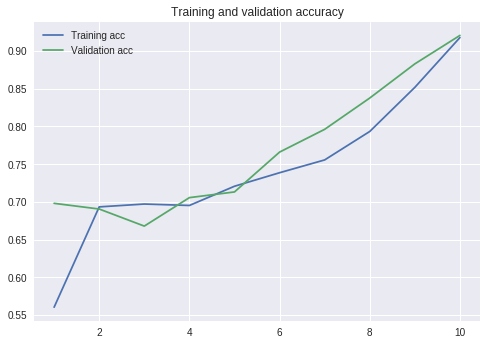

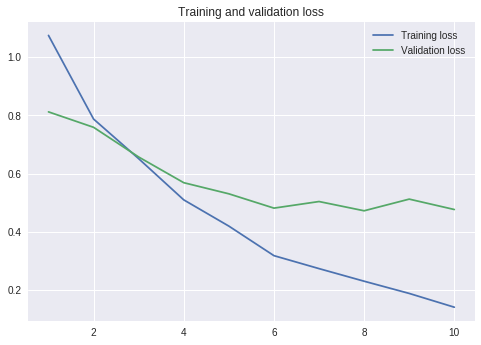

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()